# Stacked Regression to predict House prices

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color=sns.color_palette()
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm, skew


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.shape

(1460, 81)

In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
test.shape

(1459, 80)

In [7]:
# save Id column

train_Id=train['Id']
test_Id =test['Id']

In [8]:
# drop id from df

train.drop(['Id'], axis=1, inplace=True)

test.drop(['Id'], axis=1, inplace=True)

In [9]:
print('shape of the train data after dropping id: {}'.format(train.shape))
print('shape of the test data after dropping id: {}'.format(test.shape))


shape of the train data after dropping id: (1460, 80)
shape of the test data after dropping id: (1459, 79)


# Data Processing

Outliers

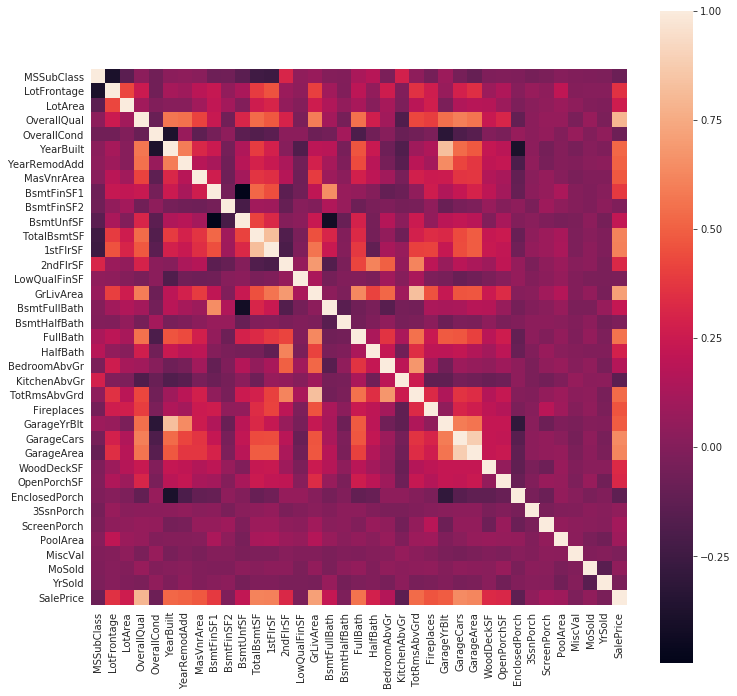

In [10]:
# correlation matrix to understand the relation between the features

corr = train.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr, square=True);

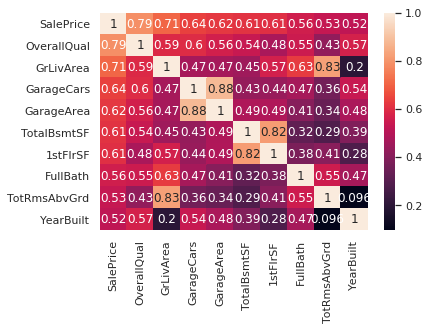

In [11]:
# correlation between the SalePrice and the other features

k=10
col=corr.nlargest(k, 'SalePrice')['SalePrice'].index

cm = np.corrcoef(train[col].values.T)
sns.set()
hm = sns.heatmap(cm, annot=True, xticklabels=col, yticklabels=col )

From this heatmap, we can see that, OverallQual, GrLivArea, GarageCars/GarageArea & TotalBsmt are highly correlated with SalePrice.

Let us plot these important/highly correlated features with target features

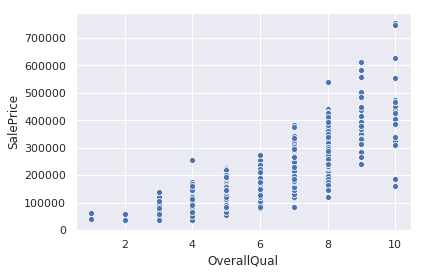

In [12]:
sns.scatterplot(x=train.OverallQual, y=train.SalePrice)

with overall quality 10, there are two low saleprice points. There can be many reasons that the SalePrice is lower like small area without many facilities. So we can't conclude that these two points are outliers!

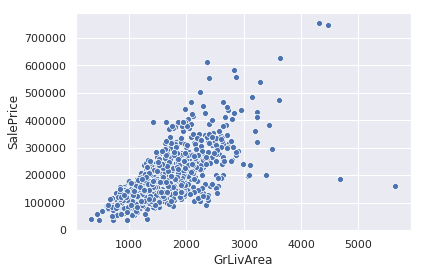

In [13]:
sns.scatterplot(x=train.GrLivArea, y=train.SalePrice)

With the large area, and small SalePrice, there are two point above 4500 GrLivArea not hanging around with the crowd. There is a big chance that these can be an outlier. So I think we can remove this. Other than these two points, there are another extreme two points above 4000 GrLivArea, but these follow the trend.  

In [14]:
# droping outliers

train = train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<200000)].index)

In [15]:
train.shape

(1458, 80)

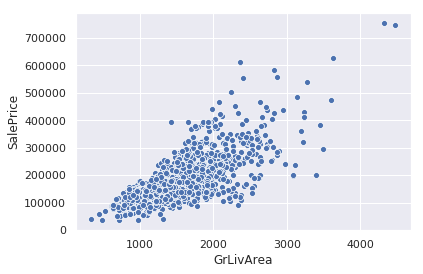

In [16]:
# check the graph once again without outliers!

sns.scatterplot(x=train.GrLivArea, y=train.SalePrice)

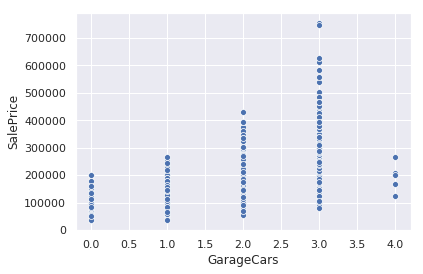

In [17]:
sns.scatterplot(x=train.GarageCars, y=train.SalePrice)

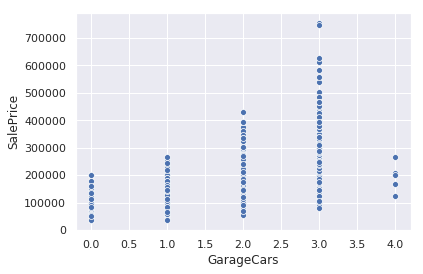

In [18]:

sns.scatterplot(x=train.GarageCars, y=train.SalePrice)

These two Garage items are similiar effects to the SalePrice and we can see that from the zoomed heatmap.

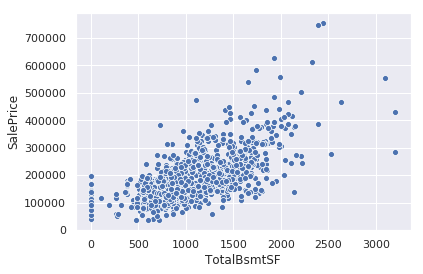

In [19]:
sns.scatterplot(x=train.TotalBsmtSF, y=train.SalePrice)

oh no! we have zeros in data. That is a problem when we need to do transform by taking log. Ok lets continue analysing the target variable.

180932.91906721535 79467.78892987774


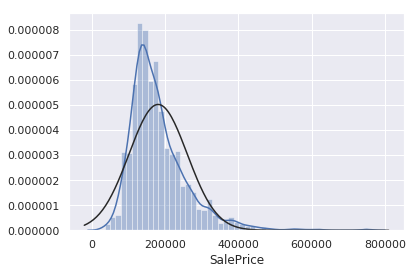

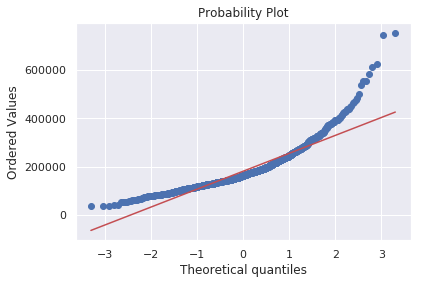

In [20]:
sns.distplot(train.SalePrice, fit=norm)
fig = plt.figure()
rest=stats.probplot(train.SalePrice, plot=plt)

(mu, sigma)=norm.fit(train.SalePrice)
print(mu, sigma)

The data distribution of the saleprice is positively skewed! Non-tree models dont like if the distribution is not normal.

Now we will look at the probability plot. It is also called QQ-plot. It is also called Quantile-Quantile plot. It is another way of looking the data distribution. It is just a plot between the quantile from the data set and the quantile from the normal distribution.Since, all the data points are not good fit to the line, the distribution is not normal.

let us see how much it is skewness and kurtosis

In [21]:
train.SalePrice.skew()

1.8812964895244009

Rule of thumb for the skew is if the skewness value is >0.5, then it is not normal. We have really a big tail on the right side. So this distribution should be transformed.

In [22]:
train.SalePrice.kurt()

6.523066888485879

Kurtosis explain the distribution at the x axis is flat or pointy. If it is flat than the value of kurtosis is 0 and if the distribution is sharp than the value will be high.

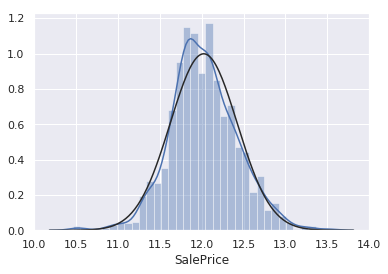

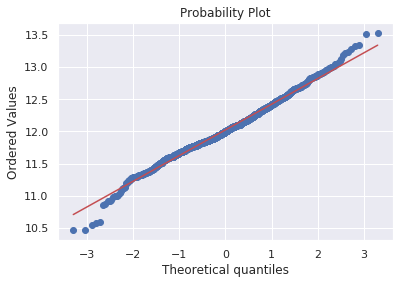

In [23]:
# Now we will transform the data by applying log(1+x) to the target feature instances

train.SalePrice=np.log1p(train.SalePrice)

# check the new distribution
sns.distplot(train.SalePrice, fit=norm)
fig=plt.figure()
res = stats.probplot(train.SalePrice, plot=plt)

In [24]:
# standard deviation and mean

print('Standard deviation: {}'.format(train.SalePrice.std()))

print('Mean: {}'.format(train.SalePrice.mean()))

Standard deviation: 0.3997128276063394
Mean: 12.02401515568252


In [25]:
(mu, sigma)=norm.fit(train.SalePrice)
print(mu, sigma)

12.024015155682552 0.3995757283645756


# Feature engineering

In [26]:
# let concatenate the train and test data in the same dataframe

In [27]:
ntrain=train.shape[0]  #no of instances in the training data
ntest=test.shape[0]    #no of instances in the test data

y_train=train.SalePrice.values
print('train data shape: {}'.format(train.shape))
print('test data shape: {}'.format(test.shape))
print('total data shape: {},{}'.format(train.shape[0]+test.shape[0], train.shape[1]))
all_data= pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.shape

train data shape: (1458, 80)
test data shape: (1459, 79)
total data shape: 2917,80


(2917, 79)

In [28]:
# missing data

In [29]:
all_data_na=((all_data.isnull().sum()/len(all_data))*100).sort_values(ascending=False)
all_data_na=all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)
print(all_data_na)
print('\nall_data_na shape {}'.format(all_data_na.shape[0]))

PoolQC          99.691464
MiscFeature     96.400411
Alley           93.212204
Fence           80.425094
FireplaceQu     48.680151
LotFrontage     16.660953
GarageFinish     5.450806
GarageQual       5.450806
GarageYrBlt      5.450806
GarageCond       5.450806
GarageType       5.382242
BsmtCond         2.811107
BsmtExposure     2.811107
BsmtQual         2.776826
BsmtFinType2     2.742544
BsmtFinType1     2.708262
MasVnrType       0.822763
MasVnrArea       0.788481
MSZoning         0.137127
BsmtHalfBath     0.068564
Utilities        0.068564
Functional       0.068564
BsmtFullBath     0.068564
BsmtFinSF1       0.034282
GarageArea       0.034282
BsmtFinSF2       0.034282
BsmtUnfSF        0.034282
TotalBsmtSF      0.034282
Exterior2nd      0.034282
Exterior1st      0.034282
GarageCars       0.034282
KitchenQual      0.034282
Electrical       0.034282
SaleType         0.034282
dtype: float64

all_data_na shape 34


In [30]:
miss_data=pd.DataFrame({'missing_data': all_data_na})
print(miss_data.shape)

(34, 1)


Text(0.5, 1.0, 'Percent of missing data by features')

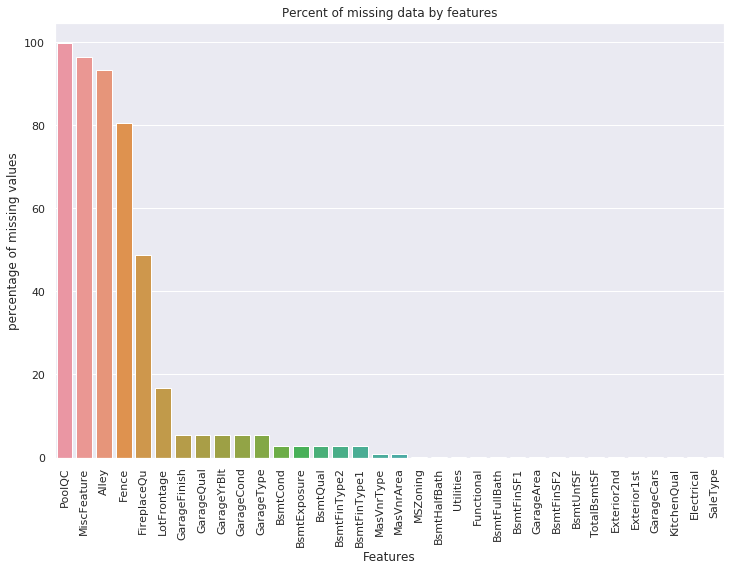

In [31]:
# plot the missing data percent
fig=plt.figure(figsize=(12,8))
sns.barplot(x=all_data_na.index, y=all_data_na);
plt.xticks(rotation='90')
plt.xlabel('Features')
plt.ylabel('percentage of missing values')
plt.title('Percent of missing data by features')

In [32]:
# From this graph, we deal the missing values feature by feature.

# 1. PoolQC - 99% of the data description says NA. ie., 99% of the houses dont have pool
all_data.PoolQC=all_data.PoolQC.fillna('None')

In [33]:
# 2. MiscFeature: 96% says no misfeature.
all_data.MiscFeature=all_data.MiscFeature.fillna('None')

In [34]:
# 3. Alley: that means no alley access
all_data.Alley=all_data.Alley.fillna('None')

In [35]:
# 4. Fence: No fence available
all_data.Fence=all_data.Fence.fillna('None')

In [36]:
# 5.FirePlaceQc: NA means fireplace quality is not available
all_data.FireplaceQu=all_data.FireplaceQu.fillna('None')

In [37]:
# 6. LotFrontage: fill the missing values with median LotFrontage of all the neighborhood.

all_data['LotFrontage']=all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    

In [38]:
# 7-11. GarageType, GarageFinish, GarageQual and GarageCond: Replace missing data with None
for col in ('GarageType','GarageFinish','GarageQual', 'GarageCond'):
    all_data[col]=all_data[col].fillna('None')

In [39]:
# 12-14. GarageYrBlt, GarageArea, GarageCars: Replacing missing values with 0
# (no garage means no cars)

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col]=all_data[col].fillna(0)

In [40]:
# 15-20 missing values of BsmtX could imply no basement (0)
for col in ('BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath'):
    all_data[col]=all_data[col].fillna(0)

In [41]:
# 21-25 missing values of qualitative details of BsmtX is none

for col in ('BsmtQual','BsmtCond','BsmtExposure', 'BsmtFinType1','BsmtFinType2'):
    all_data[col]=all_data[col].fillna('None')

In [42]:
# 26-27 MasVnr and MasVnrType: NA most likely no masonry veneer for these house (0)
all_data['MasVnrArea']=all_data['MasVnrArea'].fillna(0)
all_data['MasVnrType']=all_data['MasVnrType'].fillna(0)

In [43]:
#28 MSZoning: RL is the most common value. we can fill RL with the missing data

all_data['MSZoning']=all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [44]:
#29 Utilities: For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
all_data=all_data.drop(['Utilities'], axis=1)

In [45]:
#30 Functional: 
all_data['Functional']=all_data['Functional'].fillna('Typ')

In [46]:
# 31. Electrical: It has only one NA and mostly are SBrkr

all_data['Electrical']=all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [47]:
#32 KichenQual: TA is common. So we can fill it with TA
all_data['KitchenQual']=all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])


In [48]:
#33,34 Exterior1st and Exterior2nd: again these are having just one missing value.
all_data['Exterior1st']=all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd']=all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])


In [49]:
#35. SaleType: fill it with most common WD
all_data['SaleType']=all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])


In [50]:
#36. MSSubclass: replace it with none
# all_data['MSSubClass']=all_data['MSSubClass'].fillna('None')

In [51]:
# check for the missing value now.

all_data_na = (all_data.isnull().sum()/len(all_data))*100
all_data_na=all_data_na.drop(all_data_na[all_data_na==0.0].index).sort_values(ascending=False)

missing_data=pd.DataFrame({'Missing data': all_data_na})
missing_data.head()

,Missing data


Now we dont have missing values

Now we Transform some numerical variables to categorical

In [52]:
#MSSubClass: the building class
all_data['MSSubClass']=all_data['MSSubClass'].apply(str)

In [53]:
#Overall condition
all_data['OverallCond']=all_data['OverallCond'].apply(str)

In [54]:
# Year and Month
all_data['YrSold']=all_data['YrSold'].astype(str)
all_data['MoSold']=all_data['MoSold'].astype(str)

In [55]:
all_data.shape

(2917, 78)

### Label Encoding some categorical variables that may contains information in thier ordering set

In [56]:
from sklearn.preprocessing import LabelEncoder
cols=('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features

for c in cols:
    lbl=LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c]=lbl.transform(list(all_data[c].values))
    
print('Shape all_data {}'.format(all_data.shape))

Shape all_data (2917, 78)


In [57]:
# Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

all_data['TotalSF']=all_data['TotalBsmtSF']+all_data['1stFlrSF']+all_data['2ndFlrSF']

In [58]:
# check for skewed features

In [59]:
numeric_feats = all_data.dtypes[all_data.dtypes!='object'].index

#check for all skewed feature in numeric feats

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print('\n Skew in numerical features:\n')

skewness = pd.DataFrame({'Skew': skewed_feats})
skewness.head(30)


 Skew in numerical features:



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


#  Box cox transformation of skewed features

In [60]:
# We use the scipy function boxcox1p which computes the Box-cox transformation of 1+x

skewness = skewness[abs(skewness)>0.75]
print('There {} skewed numerical features to Box Cox transform'.format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index

lam=0.15

for feat in skewed_features:
    all_data[feat]=boxcox1p(all_data[feat], lam)
    

There 59 skewed numerical features to Box Cox transform


In [61]:
# Getting dummy categorical variables

all_data=pd.get_dummies(all_data)
print(all_data.shape)
all_data.head()

(2917, 221)


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,11.692623,11.686189,0.0,0.730463,1.540963,1.820334,1.540963,11.170327,0.0,1.194318,...,0,0,0,0,0,0,0,0,0,1
1,12.792276,0.000000,0.0,0.730463,1.540963,1.820334,0.730463,12.062832,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,1
2,11.892039,11.724598,0.0,0.730463,1.540963,1.820334,1.194318,10.200343,0.0,1.194318,...,0,0,0,0,0,0,0,0,0,1
3,12.013683,11.354094,0.0,0.730463,1.540963,0.730463,1.540963,8.274266,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,1
4,12.510588,12.271365,0.0,0.730463,1.820334,1.820334,0.000000,10.971129,0.0,1.194318,...,0,0,0,0,0,0,0,0,0,1


In [62]:
# Getting new train and test sets

train=all_data[:ntrain]
test=all_data[ntrain:]

# Modelling

In [63]:
# import libraries

In [64]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb


Define a cross validation strategy

we use cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [79]:
# Validation function

n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error', cv=kf))
    return rmse

Base models

### Lasso Regression:
This model may be sensitive to outliers. So we need to make it more robust on them. For that we use the sklearn's Robustscalar() method on pipeline

In [77]:
lasso=make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

### Elastic Net Regression
again made robust to outliers

In [68]:
ENet=make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3))

### Kernel Ridge Regression


In [69]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

### Gradient Boosting Regression
with huber loss that makes it robust to outliers

In [70]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=5)

### XGBoost

In [72]:
model_xgb=xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3,
                          min_child_weight=1.7817, n_estimators=2200, reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213, silent=1, random_state=7, nthread=-1)

### LightGBM

In [73]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05, n_estimators=720, max_bin=55, bagging_fraction = 0.8, bagging_freq=5, feature_fraction=0.2319, feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

### Basic model scores

In [82]:
score = rmsle_cv(lasso)
print('\nLasso Score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))



Lasso Score: 0.1115 (0.0074)



In [83]:
score = rmsle_cv(ENet)
print('\nElasticNet Score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))



ElasticNet Score: 0.1116 (0.0074)



In [84]:
score = rmsle_cv(KRR)
print('\nKernel Ridge Score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))



Kernel Ridge Score: 0.1153 (0.0075)



In [85]:
score = rmsle_cv(GBoost)
print('\n Gradient Boost Score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))



 Gradient Boost Score: 0.1160 (0.0078)



In [86]:
score = rmsle_cv(model_xgb)
print('\nXgboost Score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))



Xgboost Score: 0.1158 (0.0063)



In [87]:
score = rmsle_cv(model_lgb)
print('\nLGBM Score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))



LGBM Score: 0.1155 (0.0052)



## Stacking models

Simplest stacking approach: Averaging base models
    
    We begin with simple approach of averagin base models. We build a new class to extend scikit-learn with our model to laverage encapsulation and code reuse (inhertance)

In [104]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models=models  
        
#         # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_=[clone(x) for x in self.models]   

#         # Train cloned base models
        for model in self.models_:
            model.fit(X,y)
        return self
    

# Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)
      

### Averaged base model score

we just average four models here ENet, GBoost, KRR, lasso. Of course we could easily add more models in the mix

In [105]:
averaged_models = AveragingModels(models=(ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f}({:.4f})\n".format(score.mean(), score.std()))


Averaged base models score: 0.1086(0.0075)



It seems even the simplest stacking approach really improve the score. This encourages us to go further and explor the less simple stacking approach

### Less simple stacking: Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model.

The procedure, for the training part, may be described as follows:

Split the total training set into two disjoint sets (here train and .holdout )

Train several base models on the first part (train)

Test these base models on the second part (holdout)

Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration, we train every base model on 4 folds and predict on the remaining fold (holdout fold).

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of all base models on the test data and used them as meta-features on which, the final prediction is done with the meta-model.

For further reading please refer this link 
http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/

### Stacking averaged model class

In [112]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [113]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1084 (0.0072)


### Ensembling StackedRegression, XGBoost and LightGBM

#### we add XGBoost and LightGBM to the StackedRegressor defined precisely



First define a remsle evaluation function

In [114]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [115]:
### Final Training and Prediction

#### StackedRegressor

stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.08056085970783594


### XGBoost

In [118]:
%time
model_xgb.fit(train, y_train)
xgb_train_pred =  model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs
0.0794860219383189


### LightGBM

In [119]:
%time
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.7 µs
0.07209011056656395


In [121]:
### 'RMSE' on the entire Train when averaging
%time
print('RMSLE score on train data:')
print(rmsle(y_train, stacked_train_pred*.50+xgb_train_pred*.25+lgb_train_pred*.25))

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.7 µs
RMSLE score on train data:
0.07546799832347129


### Ensemble prediction:



In [123]:
ensemble = stacked_pred*.50 + xgb_pred*.25 + lgb_pred*.25

In [124]:
# Submission

sub=pd.DataFrame()
sub['Id']=test_Id
sub['SalePrice']=ensemble
sub.to_csv('submission.csv', index=False)